# Figure S5. Parity plots of GlassNet and RF predictions on several ternary silicate systems.

Make sure environment is using `glasspy 0.5.0`, currently available in the `dev` branch of [`glasspy`](https://github.com/drcassar/glasspy).

The "true" values here were generated with CALPHAD.

In [3]:
from glasspy.predict.models import GlassNet
from glasspy.data import SciGlass, sciglass_dbinfo
from glasspy.chemistry.convert import to_array, wt_to_mol

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau, zscore
from scipy.constants import pi
import seaborn as sns
import pandas as pd
import numpy as np

from utils import get_gs

In [2]:
myrcparams = {
    'axes.labelsize': 20,
    'axes.titlesize': 18,
    'axes.labelcolor': 'black',
    'xtick.labelcolor': 'black',
    'ytick.labelcolor': 'black',
    #'axes.xmargin': 0,
    #'axes.ymargin': 0,
    'legend.fontsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'figure.autolayout': True,
    'figure.figsize': (4.5,4)
}
plt.rcParams.update(myrcparams)

# Data

## Load GlassNet training and test data

In [4]:
glassnet_stnn = GlassNet()
glassnet_train_df = glassnet_stnn.get_training_dataset()
glassnet_test_df = glassnet_stnn.get_test_dataset()

In [5]:
X_glassnet_test = glassnet_test_df.elements
X_glassnet_train = glassnet_train_df.elements
X_glassnet_total = pd.concat( (X_glassnet_train, X_glassnet_test) )

In [6]:
X_glassnet_feats_test, feats = glassnet_stnn.featurizer(X_glassnet_test, return_cols = True)
X_glassnet_feats_train, feats = glassnet_stnn.featurizer(X_glassnet_train, return_cols = True)

In [7]:
X_glassnet_feats_test = pd.DataFrame(X_glassnet_feats_test, columns = feats)
X_glassnet_feats_train = pd.DataFrame(X_glassnet_feats_train, columns = feats)

In [8]:
X_glassnet_feats_test.index = X_glassnet_test.index
X_glassnet_feats_train.index = X_glassnet_train.index

In [9]:
X_glassnet_feats_total = pd.concat( (X_glassnet_feats_train, X_glassnet_feats_test) )

In [10]:
y_glassnet_test = glassnet_test_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_glassnet_train = glassnet_train_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})

In [12]:
y_glassnet_train['ViscosityAtTl'] = glassnet_stnn.predict_log10_viscosity(T = y_glassnet_train.Tliq,
                                                                          composition = X_glassnet_train)

In [13]:
y_glassnet_test['ViscosityAtTl'] = glassnet_stnn.predict_log10_viscosity(T = y_glassnet_test.Tliq,
                                                                          composition = X_glassnet_test)

In [14]:
y_glassnet_total = pd.concat( (y_glassnet_train, y_glassnet_test) )

In [15]:
gs_glassnet_train = get_gs(y_glassnet_train, jez=True)
gs_glassnet_test = get_gs(y_glassnet_test, jez=True)

In [16]:
gs_glassnet_total = pd.concat( (gs_glassnet_train, gs_glassnet_test ) )

# Read in CALPHAD liquidus data and predict with ML

In [17]:
systems = ['CaO-Al2O3-SiO2', 'MgO-Al2O3-SiO2', 'CaO-FeO-SiO2', 'Na2O-CaO-SiO2']
suffix = '-liquidus-results-0_05.xls'

In [19]:
rf_direct = RandomForestRegressor()
rf_indirect = RandomForestRegressor()

y_preds_glassnet = np.zeros( (217, len(systems) ) )
y_preds_rf = np.zeros( (217, len(systems) ) )

comp_dfs = []
y_trues = []
for i,sys in enumerate( systems ): 
    df = pd.read_excel( f'../data/Equilib-{sys}{suffix}', sheet_name = 'Sheet1' )
    comp_cols = [ f"Mol-{sub}(SLAGA#1)" for sub in sys.split('-') ]
    comp_df = df[comp_cols]
    comp_df.columns = [ sub for sub in sys.split('-') ]
    comp_dfs.append(comp_df)
    y_true = df[ 'T(C)' ] + 273.15
    y_trues.append(y_true)
    mol_chem_arr = to_array(comp_df)
    X_glassnet_feats_calphad, feats = glassnet_stnn.featurizer(comp_df, return_cols = True)
    X_glassnet_feats_calphad = pd.DataFrame(X_glassnet_feats_calphad, columns = feats)
    
    #GlassNet
    y_preds_glassnet[:len(df), i] = glassnet_stnn.predict( mol_chem_arr ).rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                          'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})['Tliq']

    #RF
    this_y_train = y_glassnet_total['Tliq'].dropna()
    this_X_train = X_glassnet_feats_total.loc[ this_y_train.index, : ]
    rf_indirect.fit( this_X_train, this_y_train )
    y_preds_rf[:len(df), i] = rf_indirect.predict( X_glassnet_feats_calphad )


# Make plots

In [20]:
systems

['CaO-Al2O3-SiO2', 'MgO-Al2O3-SiO2', 'CaO-FeO-SiO2', 'Na2O-CaO-SiO2']

CaO-Al2O3-SiO2 0.7527654904580086 0.6247893240208162
MgO-Al2O3-SiO2 0.38118872966705775 -0.10148936882390158
CaO-FeO-SiO2 0.6769207682424243 0.5275656490235944
Na2O-CaO-SiO2 0.9089971790179336 0.20082193002007398


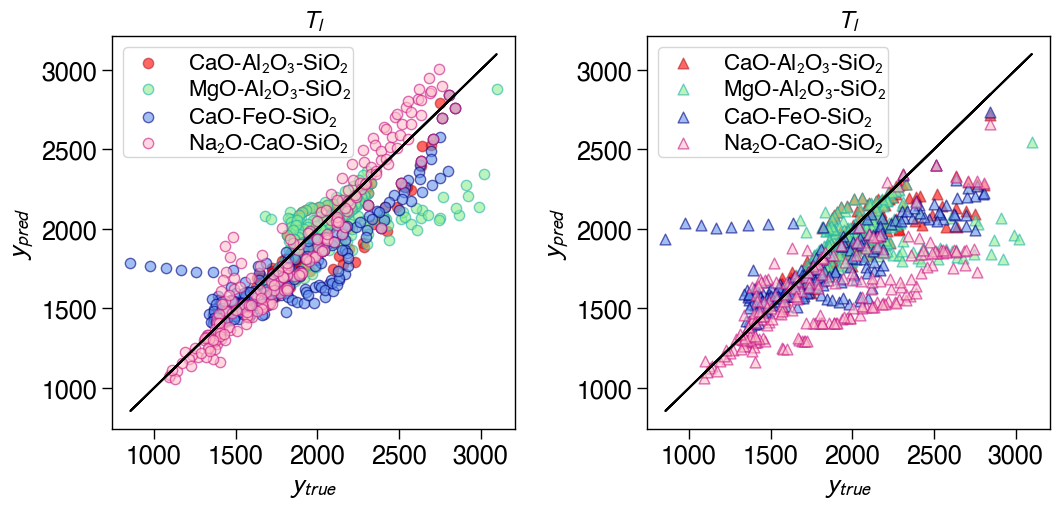

In [21]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(11,5.5))
colors = ['red', 'lightgreen', 'cornflowerblue', 'pink']
edgecolors = ['firebrick', 'lightseagreen', 'navy', 'mediumvioletred']
labels = ['CaO-Al$_2$O$_3$-SiO$_2$', 'MgO-Al$_2$O$_3$-SiO$_2$', 'CaO-FeO-SiO$_2$', 'Na$_2$O-CaO-SiO$_2$']
for i,sys in enumerate(systems):
    comp_df = comp_dfs[i]
    y_true = y_trues[i]
    y_true = y_true[ y_true < 7000 ]
    
    
    this_y_preds_glassnet = pd.Series( y_preds_glassnet[:len(comp_df), i] )
    this_y_preds_rf = pd.Series( y_preds_rf[:len(comp_df), i] )
    this_y_preds_glassnet = this_y_preds_glassnet.loc[ y_true.index ]
    this_y_preds_rf = this_y_preds_rf.loc[ y_true.index ]
    
    df_glassnet = pd.concat( (comp_df, y_true, pd.Series(this_y_preds_glassnet ) ), axis=1 )
    df_glassnet.columns = list(comp_df.columns) + ['Tliq_true', 'Tliq_pred']
    df_glassnet.to_csv(f'{sys}_calphad_tl_glassnet.csv')
    
    df_rf = pd.concat( (comp_df, y_true, pd.Series(this_y_preds_rf ) ), axis=1 )
    df_rf.columns = list(comp_df.columns) + ['Tliq_true', 'Tliq_pred']
    df_rf.to_csv(f'{sys}_calphad_tl_glassnet.csv')

    ax[0].scatter( y_true, this_y_preds_glassnet, marker='o', s=55, alpha=0.6, color=colors[i], edgecolor=edgecolors[i], label=labels[i])
    ax[1].scatter( y_true, this_y_preds_rf, marker='^', s=60, alpha=0.6, color=colors[i], edgecolor=edgecolors[i], label=labels[i])
    ax[0].plot( y_true, y_true, 'k' )
    ax[1].plot( y_true, y_true, 'k' )
    print( sys, r2_score( y_true, this_y_preds_glassnet), r2_score( y_true, this_y_preds_rf) )
ax[0].legend(labelspacing=0.1, borderpad=0.1)
ax[1].legend(labelspacing=0.1, borderpad=0.1)
ax[0].set_xlabel(r'$y_{true}$')
ax[0].set_ylabel(r'$y_{pred}$')
ax[1].set_xlabel(r'$y_{true}$')
ax[1].set_ylabel(r'$y_{pred}$')
ax[0].set_title('$T_l$')
ax[1].set_title('$T_l$')
fig.savefig( 'figureS5.png', dpi=600 )